This notebook is tested on my UMN laptop in the sunpyenv.
It is based on my previous notebook "Extract one jet from SJH catalogue" and from https://github.com/ramanakumars/SolarJets/blob/main/Jet_statistics.ipynb

## Load and read SJH catalogue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
json_file = 'exports/Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json'

In [4]:
from utils.Jet_class_light import json_import_list

In [5]:
Jet_clusters=json_import_list(json_file)

FileNotFoundError: [Errno 2] No such file or directory: 'exports/Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json'

In [5]:
# Here we have the same format as for the CSV file information
sjh_identifier = np.array([Jet_clusters[i].ID for i in range(len(Jet_clusters))], dtype=str)

# date: Observation time of the start of the jet (format YYYY-MM-DDThh:mm:ss)
Cluster_date = np.array([Jet_clusters[i].obs_time for i in range(len(Jet_clusters))], dtype='datetime64')
# duration of the jet (minutes)
stat_dur = np.array([Jet_clusters[i].Duration for i in range(len(Jet_clusters))], dtype=float)

Cluster_SOL = np.array([Jet_clusters[i].SOL for i in range(len(Jet_clusters))], dtype=str)

stat_Bx = np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))], dtype=float)
stat_By = np.array([Jet_clusters[i].By for i in range(len(Jet_clusters))], dtype=float)
stat_Lon = np.array([Jet_clusters[i].Lon for i in range(len(Jet_clusters))], dtype=float)
stat_Lat = np.array([Jet_clusters[i].Lat for i in range(len(Jet_clusters))], dtype=float)
stat_H = np.array([Jet_clusters[i].Max_Height for i in range(len(Jet_clusters))], dtype=float)
stat_W = np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))], dtype=float)
stat_vel = np.array([Jet_clusters[i].Velocity for i in range(len(Jet_clusters))], dtype=float)
stat_sigma = np.array([Jet_clusters[i].sigma for i in range(len(Jet_clusters))], dtype=float)
std_H = np.array([Jet_clusters[i].std_maxH for i in range(len(Jet_clusters))], dtype=float)
std_W = np.array([Jet_clusters[i].std_W for i in range(len(Jet_clusters))], dtype=float)
std_Bx = np.array([Jet_clusters[i].std_Bx for i in range(len(Jet_clusters))], dtype=float)
std_By = np.array([Jet_clusters[i].std_By for i in range(len(Jet_clusters))], dtype=float)
flags = np.array([Jet_clusters[i].flag for i in range(len(Jet_clusters))], dtype=str)
#angle = np.array([Jet_clusters[i].angle for i in range(len(Jet_clusters))], dtype=float)

## Some box definitions

In [6]:
from utils.Jet_box_class import make_cluster_box, make_subject_box, plot_all_subject_boxes_and_average_box

## Choose one jet and get the data

### Choose one jet

In [7]:
from astropy.coordinates import SkyCoord
import sunpy.coordinates  # Needed for helioprojective coordinate frame
from sunpy.net import Fido
from sunpy.net import attrs as a
jsoc_email = "sophie.musset@esa.int"

C:\Users\SMusset\anaconda3\envs\sunpyenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
jetid = 508

print(sjh_identifier[jetid])
selected_jet = Jet_clusters[jetid]
data_path = 'C://Users//SMusset//data//sjh_cutouts//'+selected_jet.ID
jet_box = make_cluster_box(selected_jet)

jet_start_time = selected_jet.obs_time
jet_end_time = selected_jet.obs_time + np.timedelta64(int(selected_jet.Duration*60), 's')
print(jet_start_time)
print(jet_end_time)

sjh_2015-09-22T21_1
2015-09-22T21:56:06.000000
2015-09-22T22:27:42.000000


### OPTIONAL: IF NEEDED, download the data (otherwise, skip)

Check if directory to download data exists, if not, create it

In [39]:
if not os.path.exists(data_path): os.mkdir(data_path)

Calculating the coordinates of the FOV for the cutout

In [40]:
print(jet_box.base, jet_box.height)
cutout_half_side = 60 if jet_box.height.value < 60 else jet_box.height.value + 20
print(cutout_half_side)
x1 = jet_box.base[0].value - cutout_half_side
x2 = jet_box.base[0].value + cutout_half_side
y1 = jet_box.base[1].value - cutout_half_side
y2 = jet_box.base[1].value + cutout_half_side

[ 922.16766667 -294.40316667] arcsec 196.60270234663622 arcsec
216.60270234663622


Query the cutout

In [43]:
bottom_left = SkyCoord(x1*u.arcsec, y1*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")
top_right = SkyCoord(x2*u.arcsec, y2*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")

In [48]:
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=False)

In [49]:
query = Fido.search(
    a.Time(jet_start_time, jet_end_time),
    a.Wavelength(304*u.angstrom),
    a.Sample(24*u.s),
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
    cutout,
)
print(query)

Results from 1 Provider:

80 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2015-09-22T21:56:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:36Z  SDO/AIA    AIA_4      304    2168
                 ...      ...      ...      ...     ...
2015-09-22T22:23:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T2

Download

In [50]:
files = Fido.fetch(query, overwrite=False, path=data_path)
files.sort()

Export request pending. [id=JSOC_20240422_004201, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
80 URLs found for download. Full request totalling 22MB


Files Downloaded:   0%|                                                                       | 0/80 [01:08<?, ?file/s]

80/0 files failed to download. Please check `.errors` for details


## Plot jet (one frame)

In [9]:
import glob
from sunpy import map
import astropy.units as u

In [10]:
files = glob.glob(data_path+"//aia.lev1_euv_12s.*.304.image.fits")
len(files)

80

In [11]:
aia_map = sunpy.map.Map(files[52])
jet_box.base

<Quantity [ 922.16766667, -294.40316667] arcsec>

In [12]:
jet_base_coord = SkyCoord(jet_box.base[0], jet_box.base[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")
jet_base_coord

<SkyCoord (Helioprojective: obstime=2015-09-22T22:16:54.123, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (922.16766667, -294.40316667)>

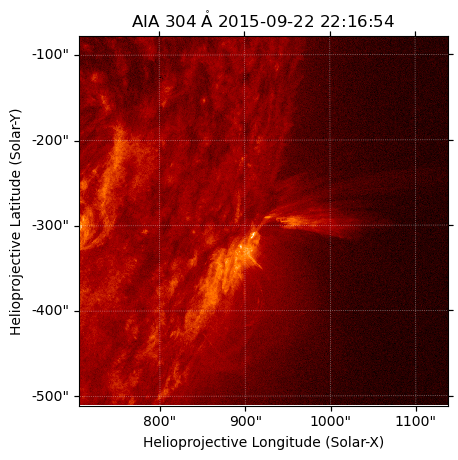

In [13]:
### fig = plt.figure(dpi=150) ### export quality
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

image = aia_map.plot(axes=ax)

plt.show()

## Plot jet and box

### Average box

In [14]:
rectangle_center_coord = SkyCoord(jet_box.center()[0], jet_box.center()[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")

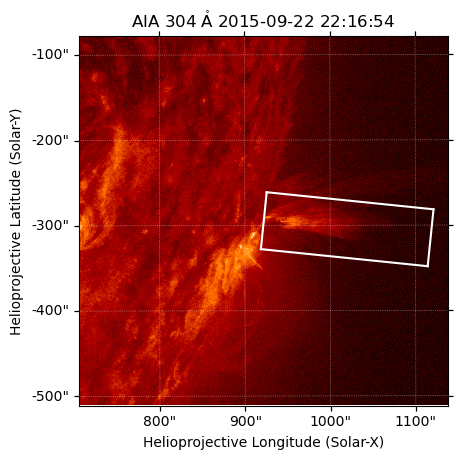

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in jet_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white',
            transform=ax.get_transform("world"))

#ax.plot_coord(rectangle_center_coord, marker='o', color='white')
plt.show()

### Plot all boxes

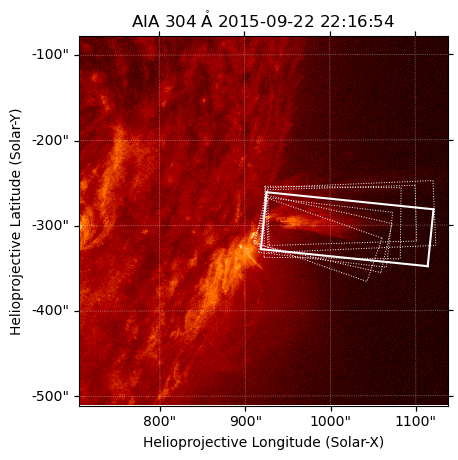

In [16]:
plot_all_subject_boxes_and_average_box(selected_jet, jet_box, aia_map)

### Plot box specifically associated to this frame

Find which subject (a subject = a sequence of 15 frames) is associated with this frame

In [17]:
subjects_start_time = []
for jet in Jet_clusters[jetid].jets:
    subjects_start_time.append(jet.time)

In [18]:
subject_idn = np.max(np.where(subjects_start_time < aia_map.date.datetime64))

In [19]:
Jet_clusters[jetid].jets[subject_idn].time

numpy.datetime64('2015-09-22T22:16:54.000000')

Make the box associated to this subject

In [20]:
subject_box = make_subject_box(Jet_clusters[jetid].jets[subject_idn])

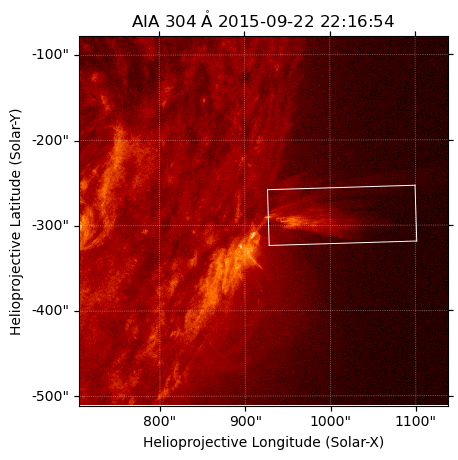

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in subject_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white', linewidth=0.7,
            transform=ax.get_transform("world"))
    
plt.show()